In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

# %matplotlib widget


In [2]:
# Standard Library Imports
import os
import csv
from datetime import datetime, timedelta, timezone
from collections import defaultdict
from collections import OrderedDict
from itertools import product
from itertools import groupby
import itertools
import pickle
import glob
import chardet
import copy
from natsort import natsorted

# Third-Party Library Imports
import numpy as np
import matplotlib.pyplot as plt
# Set a professional style for the plot
plt.style.use('_mpl-gallery')
import matplotlib.dates as mdaates
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from obspy import read, UTCDateTime
from obspy.signal.trigger import classic_sta_lta, trigger_onset, plot_trigger
from obspy import Trace
from obspy.imaging.spectrogram import spectrogram
import pandas as pd
from geopy.distance import geodesic
from tqdm.auto import tqdm
from icecream import ic
import seaborn as sns
from scipy.stats import norm, kstest, skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

# Local Imports
from energy.utils_general import *
from energy.utils_energy import *
from energy.preprocessing import *
from energy.metrics import *

A tener en consideración. Las rutas a los archivos están guardadas de la siguiente forma: *waveform_M/event_ID/channel/station/eventid_canal_horainicio_horatermino.mseed*


# 1. Creamos un diccionario con las coordenadas de las estaciones del litoral a partir del archivo Excel.

In [3]:
v_P = 8.064

file_stations_coord = os.path.join("BD paper", "catalogos","Estaciones_Chile.csv")
df = pd.read_csv(file_stations_coord, sep=';')
stations_coord_all = df.set_index('Station')[['Latitude', 'Longitude']].apply(tuple, axis=1).to_dict()
stations_names = list(stations_coord_all.keys())

# 2. Trabajar con la base de datos

### 2.1. La función z_channel_dict entrega un nested dictionary donde la primera capa de llaves indica la magnitud, la segunda capa el evento, la tercera la red de la estación que la captó, y finalmente el valor es la traza ya leída por obspy

In [4]:
# Get the path to all the folders from the folder BD paper that is in the current directory
#folders = glob.glob('BD paper/*')
folders = glob.glob(os.path.join('BD paper', '*'))
# Get all the folders in the BD paper folder that start with waveform 
#folders_signals = [folder for folder in folders if folder.startswith('BD paper/waveform')]
folders_signals = [folder for folder in folders if folder.startswith(os.path.join('BD paper', 'waveform'))]

folders_signals = sorted(folders_signals)

In [5]:
folders_signals

['BD paper/waveform_1-2.9',
 'BD paper/waveform_3p1',
 'BD paper/waveform_3p2',
 'BD paper/waveform_4p1',
 'BD paper/waveform_4p2',
 'BD paper/waveform_5',
 'BD paper/waveform_6-9']

Esta función se puede/debe optimizar. Usando os.walk probablemente sale más rápido. No sé si existe alguna forma de hacerla más generalizable eso si

In [171]:
inventory_path = "inventory"
def z_channel_dict(folders_signals, inventory_path=inventory_path):

    result_dict_z = OrderedDict()
    result_dict_e = OrderedDict()
    result_dict_n = OrderedDict()


    for folder in folders_signals:
        waveform_type = os.path.split(folder)[-1]
        events_id = natsorted(glob.glob(os.path.join(folder, '*')))

        for event_id in events_id:
            events_name = os.path.split(event_id)[-1]
            network_path = glob.glob(os.path.join(event_id, '*'))

            for network_folder in network_path:
                network_name = os.path.split(network_folder)[-1]
                
                stations_path = glob.glob(os.path.join(network_folder, '*'))

                for station_path in stations_path:
                    stations_names = os.path.split(station_path)[-1]
                    #ic(stations_names)
                    stations_path = glob.glob(os.path.join(station_path, '*'))
                    #ic(stations_path)

                    stations_ch_z = [station_z for station_z in stations_path if 'BHZ' in station_z]
                    stations_ch_e = [station_e for station_e in stations_path if 'BHE' in station_e]
                    stations_ch_n = [station_n for station_n in stations_path if 'BHN' in station_n]

                    #ic(len(stations_ch_z))
                    # Read and store traces using ObsPy
                    traces_z = []
                    traces_e = []
                    traces_n = []
                    traces = []

                    # Files to remove response
                    file_response = glob.glob(os.path.join(inventory_path, f"*{stations_names}.xml"))
                    #ic(file_response)


                    trace_z = read(stations_ch_z[0])[0]  # Assuming one trace per file
                    
                    if file_response:
                        remove_file_z = file_response[0]

                    #ic(remove_file_z)
                    trace_resp_z = trace_z.copy()
                    trace_removed_z = remove_response(trace_resp_z, remove_file_z , 'obspy')
                    #st_resp[2] = st_removed
                    st_z = trace_removed_z.copy()
                    st_z.filter('bandpass', freqmin=4.0, freqmax=10.0)
                    
                    traces_z.append(st_z)
                    #ic(stations_ch_z[0])
                    #ic(stations_ch_e)
                    #ic(stations_ch_n)

                    # trace = read(stations_ch_z[0])

                    # if len(stations_ch_e) > 0:
                    #     trace += read(stations_ch_e[0])

                    # #if len(stations_ch_n) > 0:    
                    # trace += read(stations_ch_n[0])
                    

                    # if file_response:
                    #     remove_file = file_response[0]

                    # ic(remove_file)

                    # tr_resp = trace.copy()
                    # for i in range(len(trace)):
                    #     st_removed = remove_response(tr_resp.select(channel=tr_resp[i].stats.channel)[0], remove_file , 'obspy')
                    #     tr_resp[i] = st_removed
                    #     ic(i)


                    # tr_filtered = tr_resp.copy()
                    # tr_filtered.filter('bandpass', freqmin=4.0, freqmax=10.0)

                    result_dict_z.setdefault(waveform_type, {}).setdefault(events_name, {}).setdefault(network_name, {}).setdefault(stations_names, traces_z)


    return result_dict_z

event_dict = z_channel_dict(folders_signals)


In [172]:
waveform_type = list(event_dict.keys())

# get all the events ids consideting waveform type is a list. And make events_ids a dictionary with the waveform type as keys
events_ids = {waveform_type: [int(event_id) for event_id in event_dict[waveform_type].keys()] for waveform_type in waveform_type}


### 2.2. La siguiente función pone a todas las traces de TODOS los eventos en una fila, esto lo tengo a priori, quizás habrá que arreglarlo

In [173]:
def get_all_traces(nested_dict):
    traces = []
    for value in nested_dict.values():
        if isinstance(value, dict):
            traces.extend(get_all_traces(value))
        else:
            traces.extend(value)
    return traces

# Get all ObsPy Trace objects in the dictionary
all_traces = get_all_traces(event_dict)

In [174]:
folders

['BD paper/waveform_3p1',
 'BD paper/waveform_5',
 'BD paper/waveform_3p2',
 'BD paper/waveform_1-2.9',
 'BD paper/catalogos',
 'BD paper/radio05',
 'BD paper/waveform_6-9',
 'BD paper/waveform_4p2',
 'BD paper/waveform_4p1']

### 2.3 El siguiente código es para crear un nuevo archivo CSV que contenga solo los siguientes datos:
- EventId
- Time
- Latitud
- Longitud
- Magnitud
- Estación (la que aparece automáticamente en el catálogo)
- Estaciones más cercanas (calculada con geodisic. Cantidad arbitraria)

In [ ]:
# FUNCION QUE USABA ANTES CUANDO TRABAJA CON CARPETA LISTA DE EVENTOS. PODRÍA SERVIR EN UN FUTURO

'''
def merge_coordinates(files_to_add, files_with_coord):
    
    for file_to_add, file_with_coords in zip(files_to_add, files_with_coord):
        df_to_add = pd.read_csv(file_to_add, sep=',')
        df_with_coords = pd.read_csv(file_with_coords, sep='|')

        df_to_add['Time'] = pd.to_datetime(df_to_add['Time'])
        df_with_coords['Time'] = pd.to_datetime(df_with_coords['Time'])

        df_to_add = df_to_add.set_index('Time')

        # Merge df_to_add with df_with_coords on 'Time', keeping only 'Latitude' and 'Longitude' from df_with_coords
        df_to_add = pd.merge(df_to_add, df_with_coords[['Time','Latitude', 'Longitude']], on='Time', how='left', suffixes=('', '_y'))

        # Drop the '_y' columnsbb
        df_to_add = df_to_add.drop(columns=['Latitude_y', 'Longitude_y'], errors='ignore')

        df_to_add.to_csv(file_to_add, index=False, sep = ',')


# Get all the csv files in the BD paper folder that have the word "cercanos" in their name
files_raw = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*cercanos*.csv')))
# Get all the csv files in the BD paper folder that have the word "full_data" in their name
files_full_data = sorted(glob.glob(os.path.join('BD paper', 'lista de datos','*full_data*.csv')))


# Call the function to merge coordinates for each pair of files
merge_coordinates(files_raw, files_full_data)

'''

In [175]:
# Get all the csv files in the BD paper folder that have the word "cercanos" in their name
files_raw = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*descargados*.csv')))

files_raw

['BD paper/catalogos/Eventos_descargados_1-2.9.csv',
 'BD paper/catalogos/Eventos_descargados_3p1.csv',
 'BD paper/catalogos/Eventos_descargados_3p2.csv',
 'BD paper/catalogos/Eventos_descargados_4p1.csv',
 'BD paper/catalogos/Eventos_descargados_4p2.csv',
 'BD paper/catalogos/Eventos_descargados_5.csv',
 'BD paper/catalogos/Eventos_descargados_6-9.csv']

In [176]:
def filter_csv(files_raw, events_ids):
    # Columnas a mantener
    columns_to_keep = ["#EventID", "Time", "Latitude", "Longitude", "Magnitude", "Estacion"]

    for i, (waveform_type, event_ids) in enumerate(events_ids.items()):
        # Leer el archivo CSV
        df = pd.read_csv(files_raw[i], sep=';')

        # Filtrar las filas donde '#EventID' está en event_ids
        df = df[df['#EventID'].isin(event_ids)]

        # Ordernar la columna de #EventID
        df = df.sort_values(by='#EventID')

        # Mantener solo las columnas deseadas
        df = df[columns_to_keep]

        # Guardar el nuevo DataFrame en un nuevo archivo CSV
        df.to_excel(os.path.join("BD paper", "catalogos", f"{waveform_type}_filtered.xlsx"), index=False)

filter_csv(files_raw, events_ids)


### 2.4. Ahora que ya se tienen archivos .csv con columnas "Event"Time", "Magnitud", "Estación", "Latitud", "Longitud", podemos verificar efectivamente cuál es la estación más cercana y agregarla como última columna

In [177]:
files_filtered = sorted(glob.glob(os.path.join('BD paper', 'catalogos','*filtered*')))
files_filtered

['BD paper/catalogos/waveform_1-2.9_filtered.xlsx',
 'BD paper/catalogos/waveform_3p1_filtered.xlsx',
 'BD paper/catalogos/waveform_3p2_filtered.xlsx',
 'BD paper/catalogos/waveform_4p1_filtered.xlsx',
 'BD paper/catalogos/waveform_4p2_filtered.xlsx',
 'BD paper/catalogos/waveform_5_filtered.xlsx',
 'BD paper/catalogos/waveform_6-9_filtered.xlsx']

Esta función además agrega columnas con el tiempo estimado donde el sismo debería verse en la i-ésima estación más cercana.

In [178]:
def closest_station(file_path, stations_coord_all, v_P, n_closest_stations = 5):
    '''
    Actualiza todos los archivos csv con la estación más cercana a cada evento sísmico.
    '''

    for file in file_path:
        ic(file)

        # Leer el archivo CSV
        df_events = pd.read_excel(file)

        # Cambiar nombre de la columna "Time" a "Fecha UTC" y cosas en inglés por español
        df_events = df_events.rename(columns={'Time': 'Fecha UTC', 'Latitude': 'Latitud', 'Longitude': 'Longitud', 'Magnitude': 'Magnitud'})
        
        # Cambiar esta columna a formato UTC
        df_events['Fecha UTC'] = pd.to_datetime(df_events['Fecha UTC'])
        #df_events = df_events.rename(columns={'Latitude': 'Latitud', 'Longitude': 'Longitud'})

        # Escribir en el archivo CSV
        df_events.to_excel(file, index=False)

        # Tomar el valor máximo y mínimo de la magnitud en el dataframe
        max_magnitude = df_events['Magnitud'].max()
        min_magnitude = df_events['Magnitud'].min()

        df_new = calculate_detection_times(df_events, stations_coord_all, v_P, magnitude_range=(min_magnitude, max_magnitude))
        _, closest_sts_names = nearest_n_stations(df_new, stations_names, n_closest_stations)

        # Leer el archivo CSV
        df_events = pd.read_excel(file)

        # Agregar columnas para cada estación cercana
        for i in range(n_closest_stations):
            col_name = f'Estación más cercana {i+1}'
            df_events[col_name] = closest_sts_names[i]

        df_events.to_excel(file, index=False)

        # Leer el archivo CSV
        df_events = pd.read_excel(file)

        # Agregar columnas para el tiempo de inicio de cada estación cercana
        for i in range(n_closest_stations):
            col_name = f'Inicio estación más cercana {i+1}'
            df_events[col_name] = df_events.apply(lambda row: df_new.loc[row.name, f'Inicio_{row[f"Estación más cercana {i+1}"]}'], axis=1)

        # Escribir en el archivo excel
        df_events.to_excel(file, index=False)


closest_station(files_filtered, stations_coord_all, v_P)


ic| file: 'BD paper/catalogos/waveform_1-2.9_filtered.xlsx'


ic| file: 'BD paper/catalogos/waveform_3p1_filtered.xlsx'
ic| file: 'BD paper/catalogos/waveform_3p2_filtered.xlsx'
ic| file: 'BD paper/catalogos/waveform_4p1_filtered.xlsx'
ic| file: 'BD paper/catalogos/waveform_4p2_filtered.xlsx'
ic| file: 'BD paper/catalogos/waveform_5_filtered.xlsx'
ic| file: 'BD paper/catalogos/waveform_6-9_filtered.xlsx'


# 3. Procesamiento de las trazas
Ahora que ya tenemos los archivos excel con las estaciones más cercanas y con sus estimados tiempos de detección del evento, podemos empezar a trabajar con las trazas

## 3.1. Calculo de la potencia
Se deben juntar todas las trazas que pertenecen a cada intervalo de magnitud en una sola lista para luego calcular la potencia. Es decir, todas las que son entre 4 y 5, todas las que son entre 5 y 6, y todas las que son mayores que 6. 

In [179]:
list_closest_stations = ['Estación más cercana 1', 'Estación más cercana 2', 'Estación más cercana 3', 'Estación más cercana 4', 'Estación más cercana 5']

def find_matching_trace(event_dict, dataframe, waveform_key, station_columns = list_closest_stations):
    trace_list = []
    event_dict_waveform = event_dict[waveform_key]
    #ic(event_dict_waveform)

    for i in range(len(dataframe['#EventID'].astype(str))):
        channels = list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].keys())
        #station_data = list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values())
        #station_names = [key for station_dict in station_data for key in station_dict.keys()]

        station_data = {key: value for sublist in list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values()) for key, value in sublist.items()}
        #ic(station_data)
        station_names = list(station_data.keys())
    

        for column in dataframe.loc[:, station_columns]:
            station_column_value = dataframe[column].astype(str).iloc[i]

            matching_station = next((station for station in station_names if station in station_column_value), None)

            if matching_station is not None:
                #trace_list.append(station_data[0][matching_station])
                #ic(matching_station)
                #ic(station_data)
                #ic(station_data[matching_station][0])

                trace_list.extend(station_data[matching_station])
                break
            else:
                # Tu código si no hay ninguna coincidencia
                pass

    return trace_list


df_mag4p1 = pd.read_excel(files_filtered[0])
df_mag4p2 = pd.read_excel(files_filtered[1])
df_mag5 = pd.read_excel(files_filtered[2])
df_mag69 = pd.read_excel(files_filtered[3])


trace_mag4p1 = find_matching_trace(event_dict, df_mag4p1, waveform_type[0], list_closest_stations)
#trace_mag4p2 = find_matching_trace(event_dict, df_mag4p2, waveform_type[1], list_closest_stations)
#trace_mag5 = find_matching_trace(event_dict, df_mag5, waveform_type[2], list_closest_stations)
#trace_mag69 = find_matching_trace(event_dict, df_mag69, waveform_type[3], list_closest_stations)


In [180]:
def find_matching_trace_v2(event_dict, dataframe, waveform_key, station_columns = list_closest_stations):
    trace_list = []
    event_dict_waveform = event_dict[waveform_key]

    for i in range(len(dataframe['#EventID'].astype(str))):
        #channels = list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].keys())
        station_data = {key: value for sublist in list(event_dict_waveform[dataframe['#EventID'].astype(str).iloc[i]].values()) for key, value in sublist.items()}
        #ic(station_data)
        station_names = list(station_data.keys())
        

        for j, column in enumerate(dataframe.loc[:, station_columns]):
            station_column_value = dataframe[column].astype(str).iloc[i]
            matching_station = next((station for station in station_names if station in station_column_value), None)

            if matching_station is not None:
                # Cambiar el tiempo de inicio de la traza
                start_time_column = f"Inicio estación más cercana {j+1}"
                start_time = UTCDateTime(dataframe[start_time_column].iloc[i])
                #ic(start_time)
                
                trace = station_data[matching_station][0]
                #ic(trace)
                trace.stats.starttime = start_time

                trace_list.extend(station_data[matching_station])
                break

    return trace_list


df_mag12 = pd.read_excel(files_filtered[0])
df_mag3p1 = pd.read_excel(files_filtered[1])
df_mag3p2 = pd.read_excel(files_filtered[2])
df_mag4p1 = pd.read_excel(files_filtered[3])
df_mag4p2 = pd.read_excel(files_filtered[4])
df_mag5 = pd.read_excel(files_filtered[5])
df_mag69 = pd.read_excel(files_filtered[6])


trace_mag12_v2 = find_matching_trace_v2(event_dict, df_mag12, waveform_type[0], list_closest_stations)
trace_mag3p1_v2 = find_matching_trace(event_dict, df_mag3p1, waveform_type[1], list_closest_stations)
trace_mag3p2_v2 = find_matching_trace(event_dict, df_mag3p2, waveform_type[2], list_closest_stations)
trace_mag4p1_v2 = find_matching_trace_v2(event_dict, df_mag4p1, waveform_type[3], list_closest_stations)
trace_mag4p2_v2 = find_matching_trace(event_dict, df_mag4p2, waveform_type[4], list_closest_stations)
trace_mag5_v2 = find_matching_trace(event_dict, df_mag5, waveform_type[5], list_closest_stations)
trace_mag69_v2 = find_matching_trace(event_dict, df_mag69, waveform_type[6], list_closest_stations)


In [181]:
# put trace_mag4p1 and trace_mag4p2 together in one list called trace_mag4
trace_mag3_v2 = trace_mag3p1_v2 + trace_mag3p2_v2
trace_mag4_v2 = trace_mag4p1_v2 + trace_mag4p2_v2

In [182]:
_, power_events_mag12 = zip(*[energy_power(st.data) for st in trace_mag12_v2])
_, power_events_mag3 = zip(*[energy_power(st.data) for st in trace_mag3_v2])
_, power_events_mag4 = zip(*[energy_power(st.data) for st in trace_mag4_v2])
_, power_events_mag5 = zip(*[energy_power(st.data) for st in trace_mag5_v2])
_, power_events_mag69 = zip(*[energy_power(st.data) for st in trace_mag69_v2])

In [183]:
print('Cantidad de eventos para cada magnitud:')
print(f'M<3: {len(power_events_mag12)}')
print(f'3<=M<4: {len(power_events_mag3)}')
print(f'4<=M<5: {len(power_events_mag4)}')
print(f'5<=M<6: {len(power_events_mag5)}')
print(f'M>=6: {len(power_events_mag69)}')
print('Total de eventos:', len(power_events_mag12) + len(power_events_mag3) + len(power_events_mag4) + len(power_events_mag5) + len(power_events_mag69))


Cantidad de eventos para cada magnitud:
M<3: 123
3<=M<4: 113
4<=M<5: 92
5<=M<6: 103
M>=6: 40
Total de eventos: 471


In [184]:
power_all_mags = [power_events_mag12,power_events_mag3,power_events_mag4, power_events_mag5, power_events_mag69]

power_over_3 = list(itertools.chain(power_events_mag3,power_events_mag4, power_events_mag5, power_events_mag69))

power_over_4 = list(itertools.chain(power_events_mag4, power_events_mag5, power_events_mag69))
power_under_4 = list(itertools.chain(power_events_mag12, power_events_mag3))

power_over_5 = list(itertools.chain(power_events_mag5, power_events_mag69))
power_under_5 = list(itertools.chain(power_under_4 , power_events_mag4))

power_under_6 = list(itertools.chain(power_under_5, power_events_mag5))

power_sep_3 = [power_events_mag12, power_over_3]
power_sep_4 = [power_under_4, power_over_4]
power_sep_5 = [power_under_5, power_over_5]
power_sep_6 = [power_under_6, power_events_mag69]


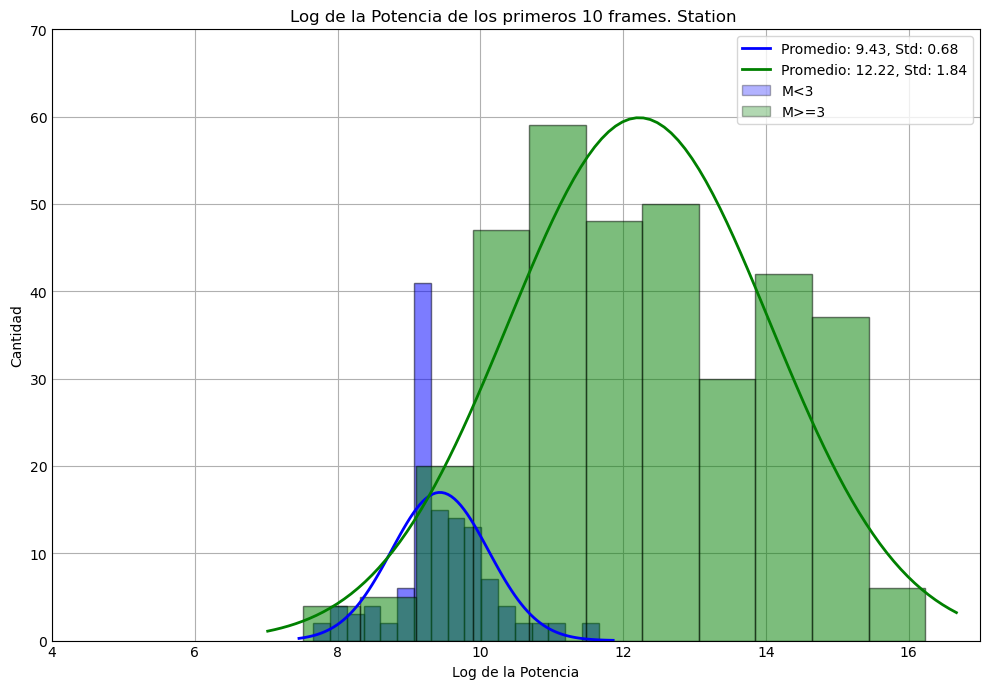

In [185]:
event_type = ['M<3','M>=3']
plot_power(power_sep_3, station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=70)

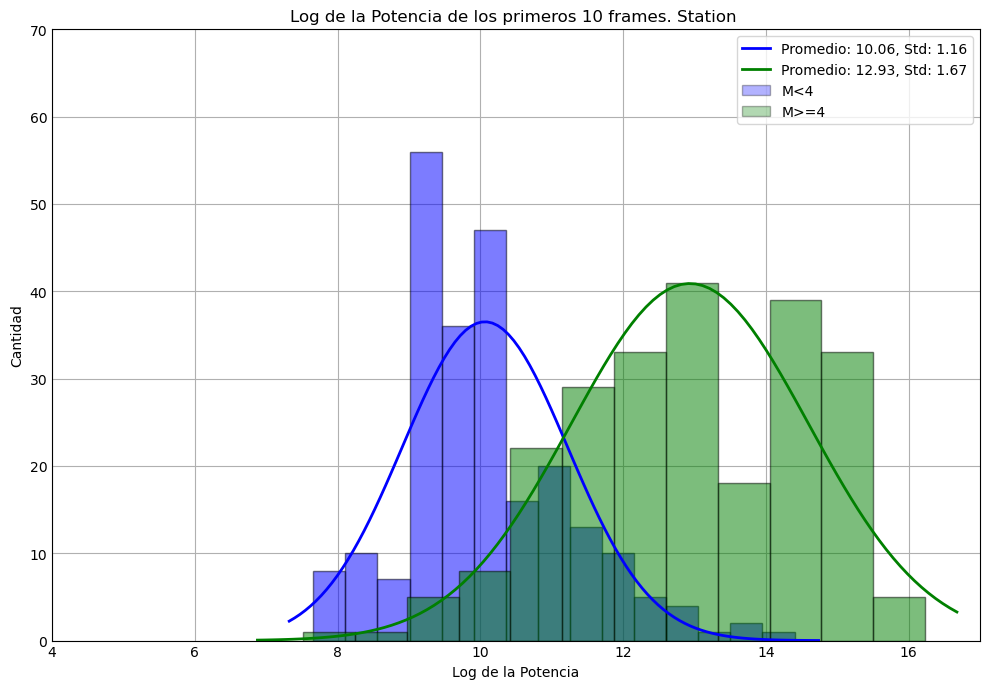

In [83]:
event_type = ['M<4','M>=4']
plot_power(power_sep_4, station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=70)

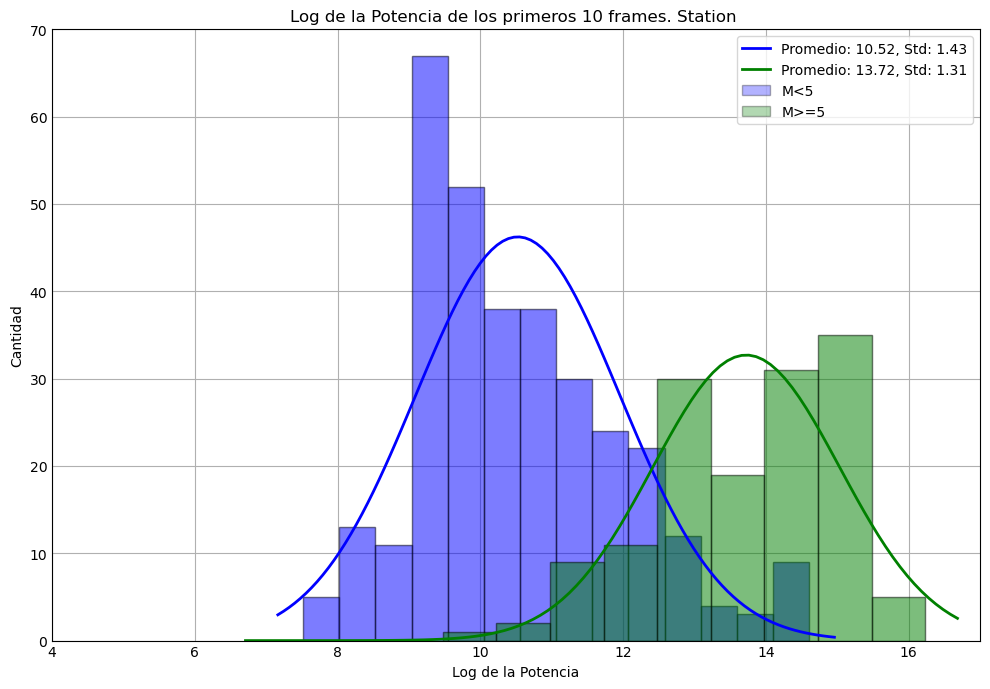

In [84]:
event_type = ['M<5','M>=5']
plot_power(power_sep_5, station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=70)

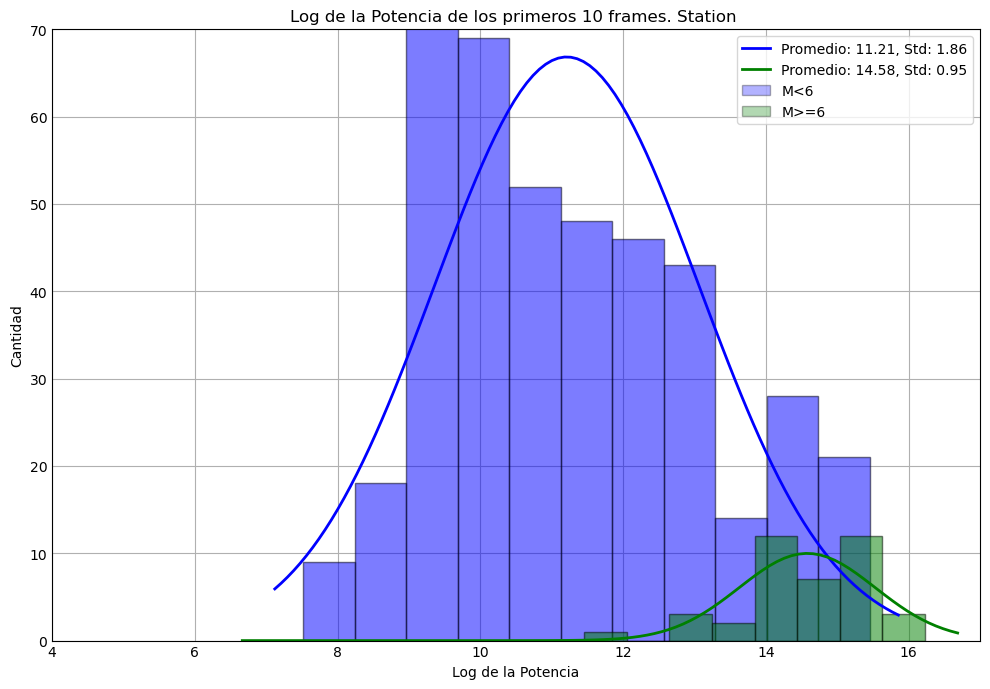

In [87]:
event_type = ['M<6','M>=6']
plot_power(power_sep_6, station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=70)

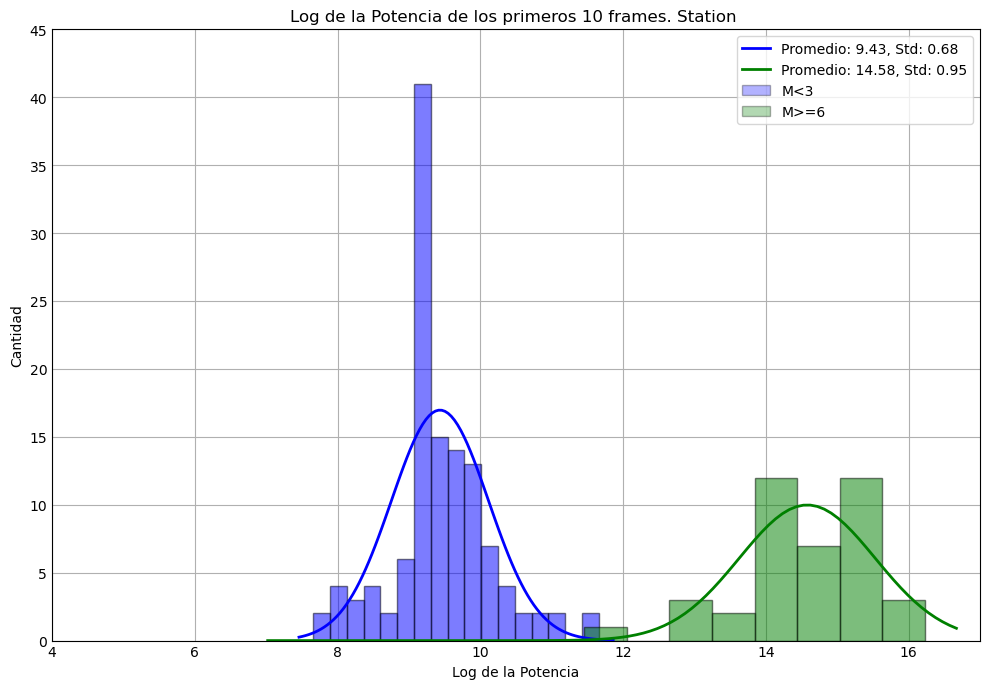

In [93]:
event_type = ['M<3','M>=6']
plot_power([power_events_mag12, power_events_mag69], station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=45)

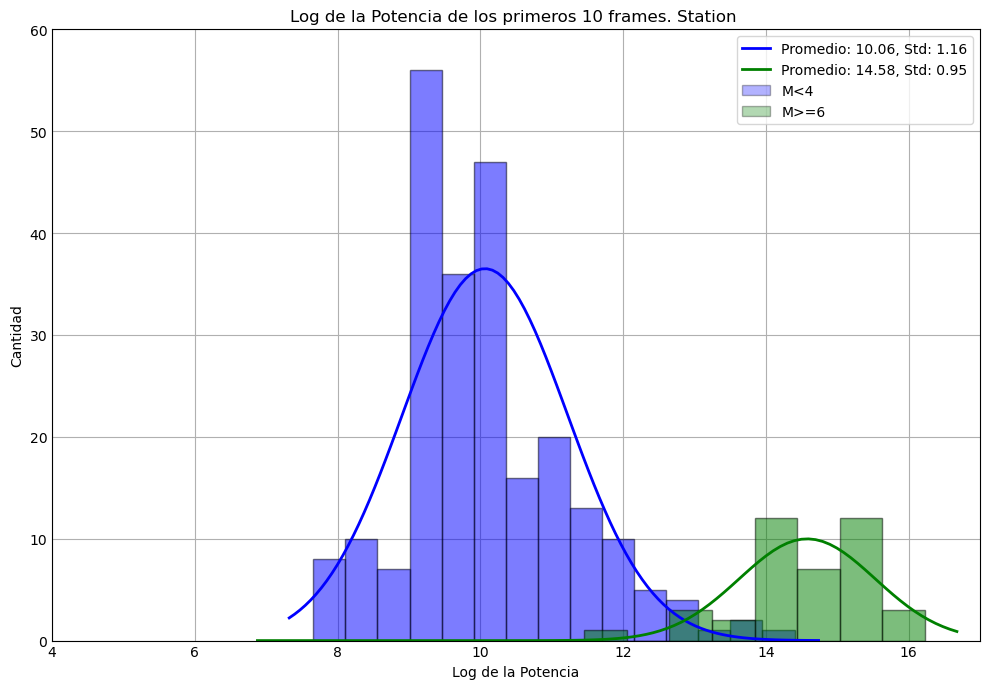

In [99]:
event_type = ['M<4','M>=6']
plot_power([power_under_4, power_events_mag69], station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=60)

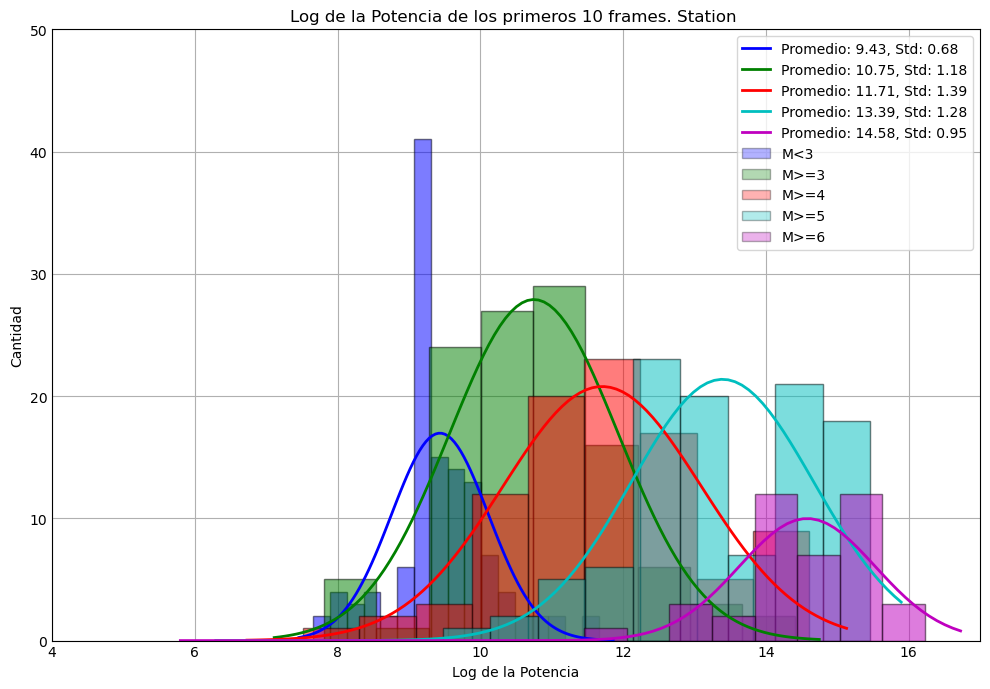

In [82]:
event_type = ['M<3','M>=3','M>=4', 'M>=5', 'M>=6']
plot_power(power_all_mags, station = '', n_frames=10, use_log=True, height = 10, width = 7, event_type=event_type, x_lim=17 ,y_lim=50)


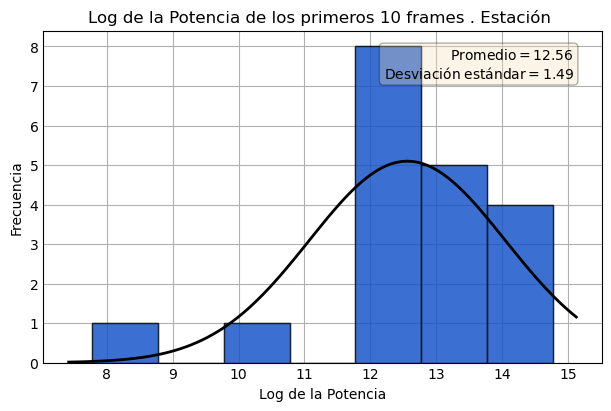

In [58]:
plot_power_each(power_events_mag4, station = '', n_frames=10, use_log = True)

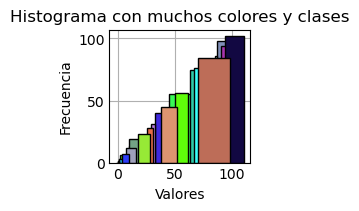

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Generar datos de ejemplo
np.random.seed(42)
data = np.random.randn(1000)

# Crear el histograma
num_bins = 30
colors = np.random.rand(num_bins, 3)

# Configurar los bordes de los bins
bin_edges, _ = np.histogram(data, bins=num_bins)

# Crear el gráfico de barras con colores personalizados
for i in range(num_bins-1):
    plt.bar(bin_edges[i], np.histogram(data, bins=num_bins)[0][i], width=bin_edges[i+1] - bin_edges[i], color=colors[i], edgecolor='black')

# Personalizar el gráfico
plt.title('Histograma con muchos colores y clases')
plt.xlabel('Valores')
plt.ylabel('Frecuencia')

# Mostrar el gráfico
plt.show()


# 4. Plot de trazas mayores que 6

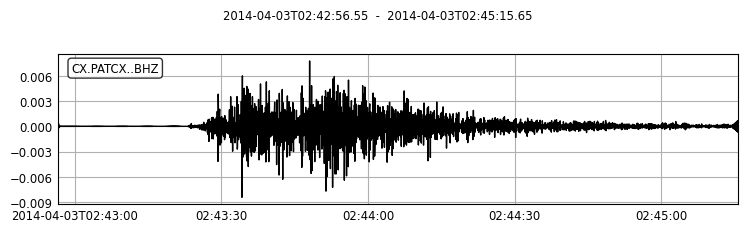

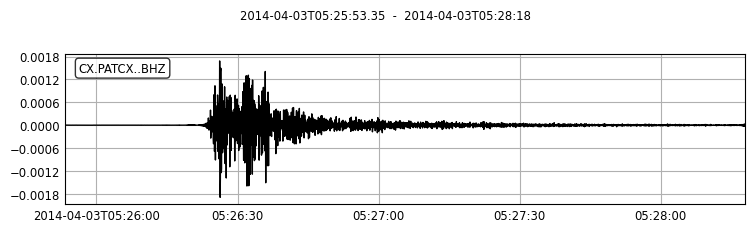

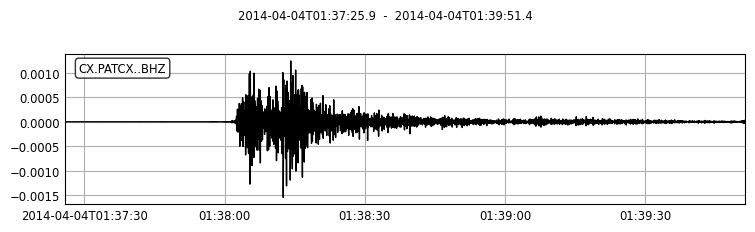

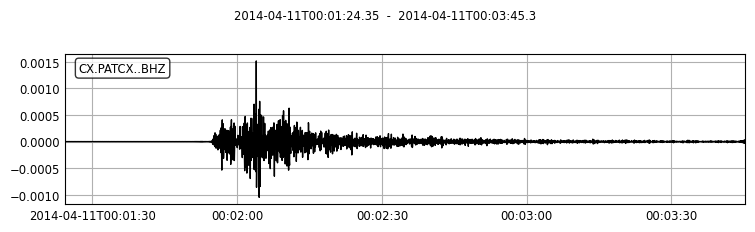

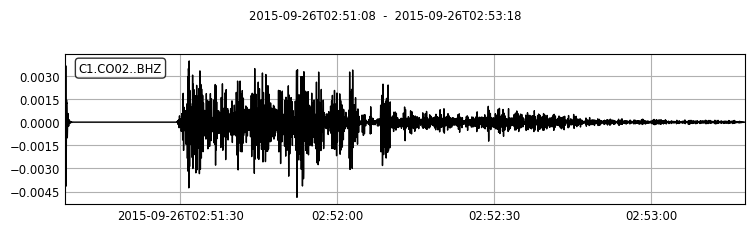

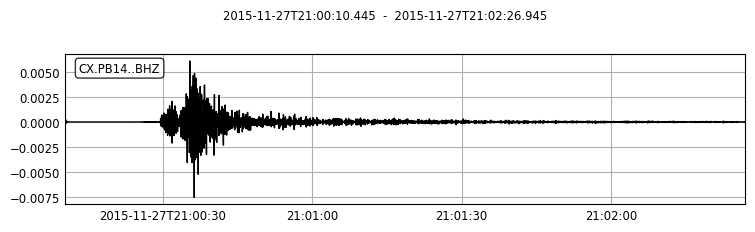

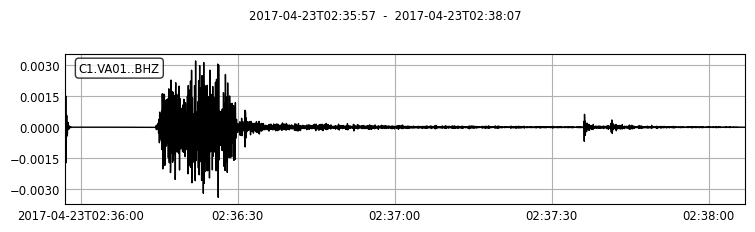

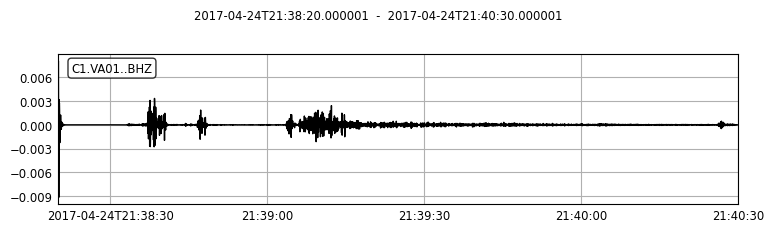

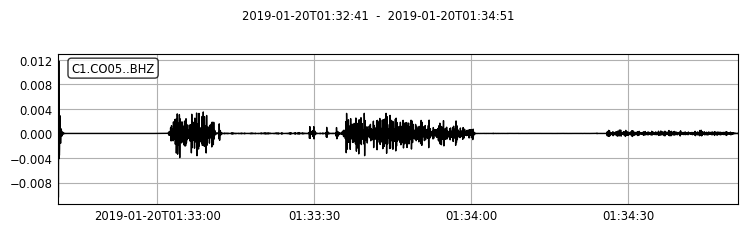

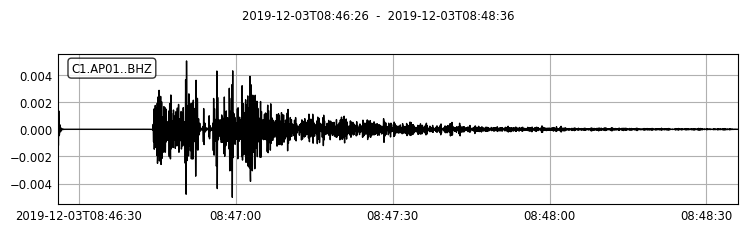

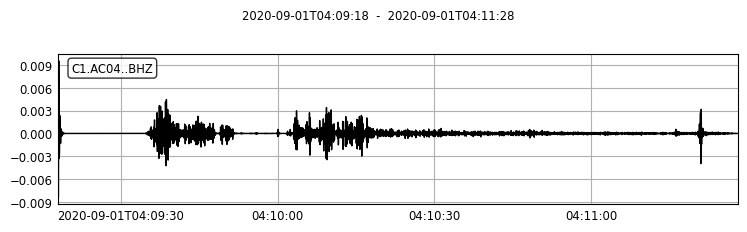

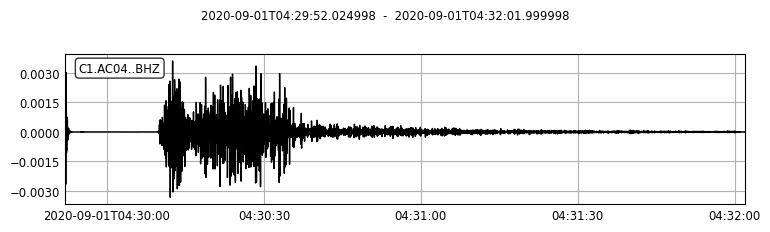

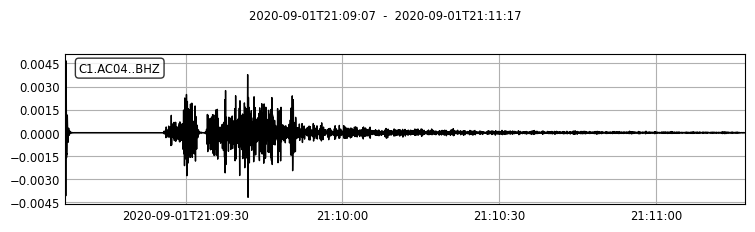

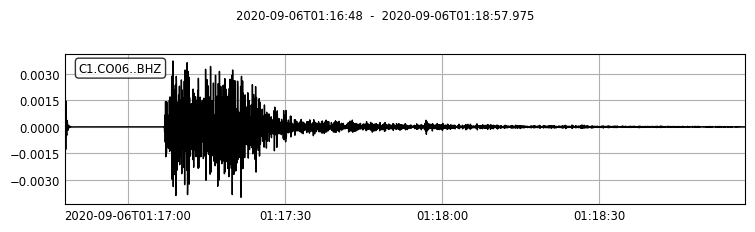

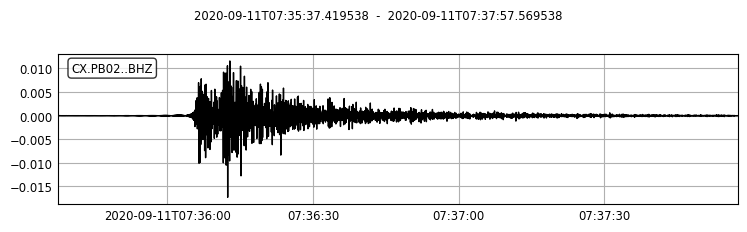

In [26]:
for tr in trace_mag69_v2:
    tr.plot()